# UNFILTERED 
# Deduplicating Common-Crawl for LLM Training Datasets. 

In this notebook, we will cover how to perform the minhash deduplication algorithm on the super-massive common crawl dataset.

Common crawl is an index of public webpages famously used to train GPT-3. LLMs require massive amounts of data to train on and early foundation models like GPT-3 and T5 saw improvements in model performance due to deduplication efforts. Deduplication makes it far less likely that the model regurgitates memorized text leading to better responses.

*See [Deduplicating Training Data Makes Language Models Better (Lee et. all)](https://aclanthology.org/2022.acl-long.577.pdf)*

---

## The MinHash Deduplication algorithm

If you google "minhash deduplication" you'll find a variety of sources that can walk you through the aglorithm. [Finding Near Duplicates with Jaccard Similarity and MinHash by Nelson Elhage](https://blog.nelhage.com/post/fuzzy-dedup/) is a great place to start, but if you are looking for the canonical reference for the MinHash deduplication algorithm, it originates from the seminal paper by Andrei Z. Broder, published in 1997, titled:

```text
"On the resemblance and containment of documents"
Published in: Proceedings of the Compression and Complexity of Sequences 1997 (SEQUENCES '97)
Publisher: IEEE Computer Society
DOI: 10.1109/SEQUEN.1997.666900
```

A video walkthough of the algorithm is also available through [Mike Mull's presentation on YouTube](https://www.youtube.com/watch?v=KKNPmvELUP4). He even provides a [jupyter notebook](https://github.com/papers-we-love/san-diego/blob/master/presentations/2016-11-03-resemblance-containment-documents/Broder97.ipynb) detailing the core primatives and how they are calculated in pure python. 


## Authenticating with AWS to access S3

Crawl data is free to access by anyone from anywhere. The data is hosted by Amazon Web Services’ Open Data Sets Sponsorships program on the bucket s3://commoncrawl/, located in the US-East-1 (Northern Virginia) AWS Region. The most performative means of accessing Common crawl is through s3, so you'll need to authenticate with an `AWS_ACCESS_KEY_ID` or `AWS_SECRET_ACCESS_KEY`. Common Crawl data can also be accessed without authentication, anonymously via it's http endpoint. 


In [1]:
import daft
from daft.io import IOConfig, S3Config
import os
from dotenv import load_dotenv

# Make sure to define your AWS_ACCESS_KEY_ID and AWS_SECRET_ACCESS_KEY in your environment variables or in a .env file
load_dotenv()

s3_config = S3Config(
    region_name="us-east-1",
    requester_pays=True,
    key_id=os.environ["AWS_ACCESS_KEY_ID"],
    access_key=os.environ["AWS_SECRET_ACCESS_KEY"],
    anonymous=False,
)

IO_CONFIG = IOConfig(s3=s3_config)
daft.set_planning_config(default_io_config=IO_CONFIG)

DaftContext(_ctx=<builtins.PyDaftContext object at 0x103a0e570>)

## Loading Common Crawl Documents 
The Common Crawl corpus contains petabytes of data, with it's oldest entries dating back to 2008. It contains raw web page data, metadata extracts, and text extracts.

We will be accessing Common Crawl through WARC files since daft supports the format natively with `daft.read_warc(uri)`

In [2]:
NUM_ROWS = 100

In [3]:
df_warc = daft.read_warc("s3://commoncrawl/crawl-data/CC-MAIN-2018-17/segments/*/warc/*.warc.gz").limit(NUM_ROWS)
df_warc.show(3) # Inspect the first 8 rows

WARC-Record-IDUtf8,WARC-TypeUtf8,"WARC-DateTimestamp(Nanoseconds, Some(""Etc/UTC""))",Content-LengthInt64,WARC-Identified-Payload-TypeUtf8,warc_contentBinary,warc_headersUtf8
52d832af-dab9-459b-bba9-44a345e4dc90,warcinfo,2018-04-23 11:00:09 UTC,327,None,"b""robots: classic\r\nhostname: ip-10""...","{""Content-Type"":""application/warc-fields"",""WARC-Filename"":""CC-MAIN-20180423110009-20180423130009-00000.warc.gz""}"
60dd2f87-47d4-465d-b052-836da31304a1,request,2018-04-23 11:33:14 UTC,226,None,"b""GET /html/part/index27_8.html HTTP""...","{""Content-Type"":""application/http; msgtype=request"",""WARC-IP-Address"":""162.209.233.126"",""WARC-Target-URI"":""http://000cha.com/html/part/index27_8.html"",""WARC-Warcinfo-ID"":""<urn:uuid:52d832af-dab9-459b-bba9-44a345e4dc90>""}"
16295a5e-3bf4-43f3-b87d-d12fd052e893,response,2018-04-23 11:33:14 UTC,6908,application/xhtml+xml,"b""HTTP/1.1 200 OK\r\nContent-Length:""...","{""Content-Type"":""application/http; msgtype=response"",""WARC-Block-Digest"":""sha1:LX5ENMXSKMHJ4C32JPS4MADKG7RJNPTY"",""WARC-Concurrent-To"":""<urn:uuid:60dd2f87-47d4-465d-b052-836da31304a1>"",""WARC-IP-Address"":""162.209.233.126"",""WARC-Payload-Digest"":""sha1:Y5WC4JCKBGR54YAJZSXTK6QTEIJGHQLI"",""WARC-Target-URI"":""http://000cha.com/html/part/index27_8.html"",""WARC-Warcinfo-ID"":""<urn:uuid:52d832af-dab9-459b-bba9-44a345e4dc90>""}"


In [ ]:
# Lets investigate the different types of payloads we have: 
df_warc.select("WARC-Identified-Payload-Type").distinct().show()

### Step 1: Preprocessing
For the purposes of this notebook, we will focus on text/html payloads, extracting text content from html body and normalizing the text itself


In [4]:
from daft import col
from daft.functions import monotonically_increasing_id

# For the purposes of this notebook, lets focus on text/plain and text/html payloads
df_html = df_warc.where(col("WARC-Identified-Payload-Type")== "text/html")

@daft.func()
def remove_http_headers(x: str) -> str:
    if x is None:
        return ""
    if len(x.split("\r\n\r\n")) > 1:
        return x.split("\r\n\r\n")[1]
    return ""

# We also need to seperate the http headers from the payloads
df_html = (
    df_html
    .with_column("content_raw", remove_http_headers(col("warc_content").try_decode("utf-8")))
    .where(col("content_raw") != "")
)   

# Then we will simplify the dataframe to just the content and a monotonically increasing id
df_html = (
    df_html
    .with_columns_renamed({"WARC-Identified-Payload-Type": "content_type",})
    .with_column("id", monotonically_increasing_id())
    .select("WARC-Record-ID", "id", "content_type", "content_raw")
)

df_html.show(3)

### Extracting Text from HTML body

In [5]:
from selectolax.parser import HTMLParser
import re
import hashlib

# Define a UDF to extract text from HTML content, Specifically (article, main, p, h1, h2, h3, li)
@daft.func()
def extract_blocks(html: str) -> list[str]:
    tree = HTMLParser(html)
    for n in tree.css("script,style,noscript"):  n.decompose()
    blocks = []
    for node in tree.css("article, main, p, h1, h2, h3, li"):
        txt = node.text(separator=" ", strip=True)
        if not txt: 
            continue
        blocks.append(txt)
    return blocks

df_text = df_html.with_column("content_text", extract_blocks(col("content_raw")).list.join(" "))
df_text.show(3)

WARC-Record-IDUtf8,idUInt64,content_typeUtf8,content_rawUtf8,content_textUtf8
96963309-6d80-4743-9401-d50faf2f7d90,0,text/html,"<!DOCTYPE html> <!--[if IE 7]><html class=""ie7 no-js"" lang=""en-US"" xmlns:og=""//opengraphprotocol.org/schema/"" xmlns:fb=""//www.facebook.com/2008/fbml""<![endif]--> <!--[if lte IE 8]><html class=""ie8 no-js"" lang=""en-US"" xmlns:og=""//opengraphprotocol.org/schema/"" xmlns:fb=""//www.facebook.com/2008/fbml""<![endif]--> <!--[if (gte IE 9)|!(IE)]><!--><html class=""not-ie no-js"" lang=""en-US"" xmlns:og=""//opengraphprotocol.org/schema/"" xmlns:fb=""//www.facebook.com/2008/fbml""><!--<![endif]-->",
7772d841-60c2-4fd1-be96-6b704f6c36b8,1,text/html,"<!DOCTYPE html> <!--[if IE 7]><html class=""ie7 no-js"" lang=""en-US"" xmlns:og=""//opengraphprotocol.org/schema/"" xmlns:fb=""//www.facebook.com/2008/fbml""<![endif]--> <!--[if lte IE 8]><html class=""ie8 no-js"" lang=""en-US"" xmlns:og=""//opengraphprotocol.org/schema/"" xmlns:fb=""//www.facebook.com/2008/fbml""<![endif]--> <!--[if (gte IE 9)|!(IE)]><!--><html class=""not-ie no-js"" lang=""en-US"" xmlns:og=""//opengraphprotocol.org/schema/"" xmlns:fb=""//www.facebook.com/2008/fbml""><!--<![endif]-->",
1815f93d-8b84-481f-b6d4-82f1add145f7,2,text/html,"<!DOCTYPE html> <html lang=""de-DE"" class=""no-js""> <head itemscope=""itemscope"" itemtype=""http://schema.org/WebSite""> <meta charset=""UTF-8"" /> <meta name=""viewport"" content=""width=device-width, initial-scale=1"" /> <link rel=""profile"" href=""http://gmpg.org/xfn/11"" />",


# Minhash

Now that we have all of our documents normalized we can just run the `minhash` expression! No building shingles 

In [6]:
K = 64 # Number of Permutations
SEED = 42 # Seed for the hash function
NGRAM_SIZE = 5 # Size of the n-grams
index_col = "id" 
content_col = "content_text"


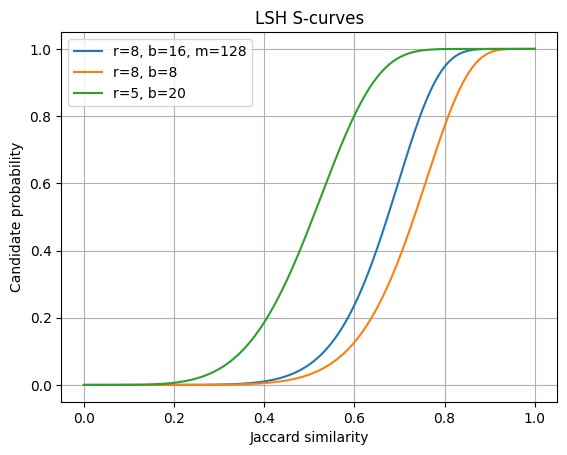

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def lsh_curve(s, r, b):
    return 1 - (1 - s**r)**b

s = np.linspace(0, 1, 500)

# Example: M=128, r=8 rows per band, b=16 bands
r, b = 8, 16
plt.plot(s, lsh_curve(s, r, b), label=f"r={r}, b={b}, m={r*b}")

# Try different settings to see how the knee shifts
plt.plot(s, lsh_curve(s, 8, 8), label="r=8, b=8")
plt.plot(s, lsh_curve(s, 5, 20), label="r=5, b=20")

plt.xlabel("Jaccard similarity")
plt.ylabel("Candidate probability")
plt.title("LSH S-curves")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# Normalize text to remove punctuation, digits, and whitespace
df_norm = df_text.with_column("content_normalized", 
    col(content_col).str.normalize(
        remove_punct=True, 
        lowercase=True, 
        nfd_unicode=True, 
        white_space=True
    )
)
df_norm.show(3)


In [8]:
df_minhash = (
    df_norm
    .with_column("min_hashes", col("content_normalized").minhash(
        num_hashes = K,
        ngram_size = NGRAM_SIZE,
        seed = SEED, 
        hash_function = 'xxhash'
        )
    )
)
df_minhash.show(3)

In [9]:
from scipy.integrate import quad as integrate

def optimal_param(
    threshold: float,
    num_perm: int,
    false_positive_weight: float = 0.5,
    false_negative_weight: float = 0.5,
):
    """
    Compute the optimal `MinHashLSH` parameter that minimizes the weighted sum
    of probabilities of false positive and false negative, taken from datasketch.

    Parameters
    ----------
    threshold : float
        The threshold for similarity.
    num_perm : int
        The number of permutations.
    false_positive_weight : float
        The weight of false positive.
    false_negative_weight : float
        The weight of false negative.

    Returns
    -------
    Tuple[int, int]
        The optimal `b` and `r` parameters.
        The number of bands, and the number of rows per band respectively.

    Examples
    --------
    >>> optimal_param(0.7, 256)
    (25, 10)
    """

    def false_positive_area(threshold: float, b: int, r: int):
        """Source: `datasketch.lsh`"""

        def area(s):
            return 1 - (1 - s ** float(r)) ** float(b)

        a, _ = integrate(area, 0.0, threshold)
        return a

    def false_negative_area(threshold: float, b: int, r: int):
        """Source: `datasketch.lsh`"""

        def area(s):
            return 1 - (1 - (1 - s ** float(r)) ** float(b))

        a, _ = integrate(area, threshold, 1.0)
        return a

    min_error = float("inf")
    opt = (0, 0)
    for b in range(1, num_perm + 1):
        max_r = int(num_perm / b)
        for r in range(1, max_r + 1):
            fp = false_positive_area(threshold, b, r)
            fn = false_negative_area(threshold, b, r)
            error = fp * false_positive_weight + fn * false_negative_weight
            if error < min_error:
                min_error = error
                opt = (b, r)
    return opt

In [ ]:
# Choose B bands and R rows per band such that B · R = num_perm.
B, R = optimal_param(0.717, K)

In [11]:
from daft import lit

# Band Generation
df_bands = (
    df_minhash
    .with_column("bands", col("min_hashes").list.chunk(R))
    .with_column("band_idx", lit(list(range(B))))
    .explode("bands", "band_idx")
    .select(index_col, "band_idx", "bands")
)
df_bands.show(20)    

idUInt64,band_idxInt64,bandsFixedSizeList[UInt32; 8]
0,0,"[14457134, 8191581, 1638159, 4404002, 2628036, 288693, 1897872, 2858348]"
0,1,"[2859655, 8214577, 78127, 398690, 846542, 2744458, 597558, 1825035]"
0,2,"[5210358, 10924070, 1311466, 6648318, 915854, 831344, 2485373, 1303552]"
0,3,"[1680414, 7807318, 1901800, 3553490, 57297, 1212351, 4393386, 5452732]"
0,4,"[788235, 681721, 3684615, 424714, 4187578, 4151396, 2394656, 483971]"
...,...,...
1,7,"[27908416, 22296288, 98974051, 11913230, 11580953, 22105557, 54447244, 39776999]"
2,0,"[1270179366, 3438978454, 3491990579, 84843336, 427723622, 2796661045, 442579479, 4246399540]"
2,1,"[3203613191, 3630649945, 3097275795, 3795350221, 3604836898, 886644346, 4132723524, 2477837690]"
2,2,"[2557416095, 3316297302, 1395661242, 3927268885, 3739666714, 2876184015, 3386316544, 3032251977]"


For each band b ∈ {0,…,B−1}, define the band slice s_{i,b} = h_i[bR : (b+1)R] ∈ [0, MAX_HASH]^R.
- Define buckets by equality of band slices:
C_{b,s} = { i | s_{i,b} = s }.
These C_{b,s} are the “bucketed bands” (candidate collision sets). Every pair of documents within the same C_{b,s} is a candidate match.
Practically, you realize this by grouping rows by (band_idx, band) and aggregating the list of document IDs as nodes.

In [13]:
# Grouping Bands
df_grouped = (
    df_bands
    .groupby(col("band_idx"), col("bands"))
    .agg(col(index_col).agg_list().alias("nodes"))
)
df_grouped.show(20)

band_idxInt64,bandsFixedSizeList[UInt32; 8],nodesList[UInt64]
2,"[6555804, 37340274, 1317498, 25913322, 15605980, 44824832, 23126567, 49555713]",[1]
5,"[18779194, 12501903, 10030411, 32349864, 29053080, 55567461, 45258776, 4983]",[1]
1,"[186955333, 260399415, 69325833, 378708885, 358111524, 899279654, 38917036, 448591702]",[5]
2,"[62262768, 206555435, 22969946, 235598933, 422670944, 84863496, 86644378, 11998543]",[5]
1,"[186955333, 416664693, 69325833, 323015516, 229071783, 173554865, 38917036, 448591702]",[12]
...,...,...
2,"[873464664, 206555435, 20367194, 567932493, 587640662, 84863496, 252764961, 11998543]","[11, 12]"
5,"[5298103, 16126660, 1373250, 4037848, 1834344, 16389673, 244986, 1145524]",[13]
1,"[3203613191, 3630649945, 3097275795, 3795350221, 3604836898, 886644346, 4132723524, 2477837690]",[2]
1,"[4294967295, 4294967295, 4294967295, 4294967295, 4294967295, 4294967295, 4294967295, 4294967295]","[4, 14]"


## Connected Components
To build edges without quadratic blowup, for each non-empty bucket C_{b,s}:
Choose a representative r = min(C_{b,s}) (or any canonical choice).
Emit star edges (r, j) for each j ∈ C_{b,s} \ {r}.
This yields an undirected graph whose connected components are the near-duplicate clusters.

In [15]:
# Generate Graph Edges
df_edges = (
    df_grouped
    .with_column("left_edge", col("nodes").list.min())
    .explode("nodes")
    .select("left_edge", right_edge=col("nodes"))
    .filter(col("left_edge") != col("right_edge"))
    .distinct()
)
df_edges.show(3)

left_edgeUInt64,right_edgeUInt64
1,8
1,28
7,14


What we have: An undirected graph where each row is an edge left_edge -> right_edge meaning two documents likely match (they co-occurred in at least one band).

What we want: Assign a single representative ID per connected cluster of documents, so we can keep one per cluster (e.g., the minimum ID).

### Star Contraction
Now we will iteratively compress the graph using two alternating phases until convergence:
- Large-star: Every node points to the minimum ID in its neighborhood (including itself). This quickly pulls nodes toward low-ID “hubs.”
- Small-star: Re-orient edges to ensure u < v (canonicalize) and repeat contraction, which merges local hubs together.
- Repeat large-star then small-star until nothing changes. The “parent” each node ends up pointing to is its component representative.

### 1. Canonicalize edges to undirected form
Ensure we treat the graph as undirected by unioning (u,v) with (v,u).

In [17]:
from daft import Expression, struct, DataFrame

def ee(u: Expression, v: Expression):
    return struct(u.alias("u"), v.alias("v")) 

### 2. Large-star phase
- Group neighbors by u.
- Compute min_neighbor = min(neighbors).
- Use min(u, min_neighbor) as the node’s “parent.”
- Emit edges (u, parent) but only where parent > u to avoid self-loops and duplicates.

In [18]:
def large_star_phase(df: DataFrame):
    return (
        df
        # large_star_map
        .select("u", "v")
        .union_all(b.select(col("v").alias("u"), col("u").alias("v")))

        .groupby("u").agg_list("v")
        # large_star_reduce
        .with_column("min_edge", col("v").list.min())
        .with_column("min_edge", (col("u") <= col("min_edge")).if_else(col("u"), col("min_edge")))
        .select(col("u").list.map(ee(daft.element(), col("min_edge"))).alias("e"), col("u"))

        .explode("e")
        .where(col("e")["v"] > col("u")).select("e")
        .where(~col("e").is_null())
        .distinct()
        .select(col("e")["*"])
        .where(col("u") != col("v"))
        .collect() # Materialize
    )

### 3. Small-star phase
- Re-orient all edges so u < v (canonical).
- Group neighbors by u, compute min_neighbor, connect (u, parent) like above.
- This step merges local minima across previously separate stars.

In [ ]:
def small_star_phase(df: DataFrame):
    return (
        df
        # small_star_map
        .select((col("u") > col("v")).if_else(ee(col("u"), col("v")), ee(col("v"), col("u"))).alias("e"))
        .select(col("e")["*"])

        .groupby("u").agg_list("v")
        # small_star_reduce
        .with_column("min_edge", col("v").list.min())
        .with_column("min_edge", (col("u") <= col("min_edge")).if_else(col("u"), col("min_edge")))
        .select(col("u").list.map(ee(daft.element(), col("min_edge"))).alias("e"), col("u"), col("min_edge"))
        # TODO: list_append

        .explode("e")
        .where(~col("e").is_null())
        .distinct()
        .select(col("e")["*"])
        .collect() # Materialize
  )

### 4. Convergence check
- Compare a stable summary of edges before/after (hash sum is fine).
- If stable, stop; otherwise repeat.

In [ ]:
def check_convergence(a: DataFrame, b: DataFrame):
    a_hash = a.select(col("u").hash().alias("hash")).sum("hash").to_pydict()["hash"][0]
    b_hash = b.select(col("u").hash().alias("hash")).sum("hash").to_pydict()["hash"][0]
    if a_hash == b_hash:
        return True

### Combining Stages

In [21]:
def connected_components(
    edges: DataFrame,     
    left_id_col="left_edge",
    right_id_col="right_edge",
    output_index_col=index_col,
    output_component_col="__component__",
):
    # Convert column names to u, v
    b = (
        edges.select(col(left_id_col).alias("u"), col(right_id_col).alias("v"))
        .where(~col("u").is_null())
        .where(~col("v").is_null())
        .collect()
    )    
    while True:
        a = large_star_phase(b)
        b = small_star_phase(a)
        if check_convergence(a, b):
            break
    
    # Revert column names and return contracted star edges
    return (
        b
        .select(col("u").alias(output_index_col), col("v").alias(output_component_col))
        .collect()
    )
    

In [23]:

def components(
    df: DataFrame,
    left_id_col: str = "u",
    right_id_col: str = "v",
    output_index_col: str = "u",
    output_component_col: str = "component"
) -> DataFrame:
    b = (
        df.select(col(left_id_col).alias("u"), col(right_id_col).alias("v"))
        .where(~col("u").is_null())
        .where(~col("v").is_null())
        .collect()
    )    
    while True:
        a = (b
             # large_star_map
             .select("u", "v")
             .union_all(b.select(col("v").alias("u"), col("u").alias("v")))

             .groupby("u").agg_list("v")
             # large_star_reduce
             .with_column("min_edge", col("v").list.min())
             .with_column("min_edge", (col("u") <= col("min_edge")).if_else(col("u"), col("min_edge")))
             .select(col("u").list.map(ee(daft.element(), col("min_edge"))).alias("e"), col("u"))

             .explode("e")
             .where(col("e")["v"] > col("u")).select("e")
             .where(~col("e").is_null())
             .distinct()
             .select(col("e")["*"])
             .where(col("u") != col("v"))
             .collect()
        )
        b = (a
             # small_star_map
             .select((col("u") > col("v")).if_else(ee(col("u"), col("v")), ee(col("v"), col("u"))).alias("e"))
             .select(col("e")["*"])

             .groupby("u").agg_list("v")
             # small_star_reduce
             .with_column("min_edge", col("v").list.min())
             .with_column("min_edge", (col("u") <= col("min_edge")).if_else(col("u"), col("min_edge")))
             .select(col("u").list.map(ee(daft.element(), col("min_edge"))).alias("e"), col("u"), col("min_edge"))
             # TODO: list_append

             .explode("e")
             .where(~col("e").is_null())
             .distinct()
             .select(col("e")["*"])
             .collect()
        )
        # check convergence
        a_hash = a.select(col("u").hash().alias("hash")).sum("hash").to_pydict()["hash"][0]
        b_hash = b.select(col("u").hash().alias("hash")).sum("hash").to_pydict()["hash"][0]
        if a_hash == b_hash:
            return (
                b
                .select(col("u").alias(output_index_col), col("v").alias(output_component_col))
                .collect()
            )

In [25]:
assignment = components(
    df_edges,
    left_id_col="left_edge",
    right_id_col="right_edge",
    output_index_col=index_col,
    output_component_col="__component__",
)


/Users/everett-founder/git/ugh/daft-minhash-dedupe/.venv/lib/python3.11/site-packages/daft/dashboard/__init__.py:91: UserWarning: Failed to broadcast metrics over http://127.0.0.1:3240/api/queries: HTTP Error 400: Bad Request
  warnings.warn(f"Failed to broadcast metrics over {url}: {e}")




🗡️ 🐟 Warc Scan: 00:00 64 rows emitted, 0 B bytes read










🗡️ 🐟 Warc Scan: 00:00 64 rows emitted, 0 B bytes read





🗡️ 🐟 Warc Scan: 00:00 64 rows emitted, 0 B bytes read










































































































🗡️ 🐟 Warc Scan: 00:00 128 rows emitted, 0 B bytes read






















































































































































































































































































































DaftCoreException: DaftError::External Unable to create logical plan node.
Due to: DaftError::ComputeError Input must be a list

In [24]:
# Running the Star Contraction
df_star_edges = connected_components(
    edges=df_edges,
    left_id_col="left_edge",
    right_id_col="right_edge",
    output_index_col=index_col,
    output_component_col="__component__",
)
df_star_edges.show(3)


/Users/everett-founder/git/ugh/daft-minhash-dedupe/.venv/lib/python3.11/site-packages/daft/dashboard/__init__.py:91: UserWarning: Failed to broadcast metrics over http://127.0.0.1:3240/api/queries: HTTP Error 400: Bad Request
  warnings.warn(f"Failed to broadcast metrics over {url}: {e}")


🗡️ 🐟 Warc Scan: 00:00 64 rows emitted, 0 B bytes read



































🗡️ 🐟 Warc Scan: 00:00 128 rows emitted, 0 B bytes read
































































































































































































































































































































































































AttributeError: 'int' object has no attribute 'select'

### 5. Final assignment
- Treat the final v for each u as the component representative.
- Join back to your documents and keep the representative per component.

In [ ]:
# Keep one per component (the representative equals the index)
 (
    df
    .join(assignment.select(col(index_col), col("__component__")), on=index_col, how="left")
    .filter(col("__component__").is_null() | (col("__component__") == col(index_col)))
    .exclude("__component__")
)